### Import libraries

In [1]:
import pytesseract as pt
from PIL import Image
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [2]:
# Tesseract path

pt.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [3]:
# Make directories

if not os.path.exists('./tesseract'):
        os.mkdir('./tesseract')
if not os.path.exists('./results'):
    os.mkdir('./results')

### Utility functions

In [4]:
# Get size of an input image

def img_size(image):
    size = len(image) * len(image[0])
    return size

In [5]:
# Get histogram of an input image

def get_hist(image):
    bins = range(0,257)
    img_histogram = np.histogram(image, bins)
    return img_histogram

In [47]:
# Open files from path, strip whitespace and newlines as requested

def get_file(path, doStrip):
    results = open(f"tesseract/{path}.txt", "r")
    results = results.read()
    if doStrip:
        results = results.replace(" ", "")
        results = results.replace("\n", "")
    return results

In [7]:
# Process and save tesseract output of an image

def process_tesseract(file_name, processed):
    print(pt.image_to_string(processed))
    with open(f"tesseract/{file_name}_output.txt", "w") as text_file:
        text_file.write(pt.image_to_string(processed))

# Global Thresholding with Otsu
---

In [77]:
# Implementation of binary threshold, used in otsu algorithm

def binary_thresh(image, thresh):
    for height in range(len(image)):
        for width in range(len(image[0])):
            if image[height,width] <= thresh:
                image[height,width] = 0
            else:
                image[height,width] = 255
    return image

In [11]:
def otsu(image, do_savefile):
    hist = get_hist(image)
    size = img_size(image)
    current_max, th = 0, 0
    sumT, sumF, sumB = 0, 0, 0
    for i in range(0,256):
        sumT += i * hist[0][i]
    weightB, weightF = 0, 0
    varBetween, meanB, meanF = 0, 0, 0
    for i in range(0,256):
        weightB += hist[0][i]
        weightF = size - weightB
        if weightF == 0:
            break
        sumB += i*hist[0][i]
        sumF = sumT - sumB
        meanB = sumB/weightB
        meanF = sumF/weightF
        varBetween = weightB * weightF
        varBetween *= (meanB-meanF)*(meanB-meanF)
        if varBetween > current_max:
            current_max = varBetween
            th = i 
    
    thresh = binary_thresh(image,th)
    if do_savefile:
        cv.imwrite(f'results/{file_name}_global.png',thresh)
    return thresh

2


<ipython-input-11-1f2d5cf014e7>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  meanB = sumB/weightB


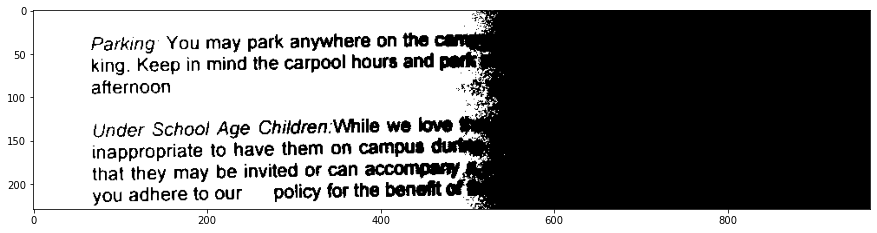

In [14]:
file_name = "sample01"
try:
    img = cv.imread(f'{file_name}.png',0)
    print(img.ndim)
    if img.ndim > 2:
        img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
except IOError:
    print ("Unable to open file. Please try another format.")

thresh = otsu(img,True)
plt.figure(figsize=(15,10))
plt.imshow(thresh,'gray')

In [15]:
# Tesseract results of global otsu thresholding

process_tesseract(f'{file_name}_global', thresh)

Parking You may park anywhere on the cf
king. Keep in mind the carpool hours and peri,
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ i
that they may be invited or can accompany J
you adhere to our —_policy for the benefit of

 



# Adaptive Thresholding with Otsu
---

In [16]:
# Adaptive otsu algorithm
# Takes in (1) an input image array and number of intervals((2) row and (3) columns) for splitting the image

def adaptive_thresh_otsu(image, num_row, num_col):
    processed_img = image
    print(len(image))
    print(len(image[0]))
    interval_height = int(np.ceil(len(image)/num_row))
    interval_width = int(np.ceil(len(image[0])/num_col))
    print(interval_height,interval_width)
    for col in range(num_col):
        for row in range(num_row):
            lower_bound_h = row * interval_height
            upper_bound_h = (row+1) * interval_height
            lower_bound_w = col * interval_width
            upper_bound_w = (col+1) * interval_width
            if upper_bound_h > len(image):
                upper_bound_h = len(image)
            if upper_bound_w > len(image[0]):
                upper_bound_w = len(image[0])
            img_snip = image[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w]
            if img_snip.size == 0:
                continue
            processed_img[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w] = otsu(img_snip, False)
    return processed_img

In [89]:
file_name = 'sample01'
image = cv.imread(f'{file_name}.png',0)
processed = adaptive_thresh_otsu(image, 3, 13)

229
965
77 75


<ipython-input-11-1f2d5cf014e7>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  meanB = sumB/weightB


True

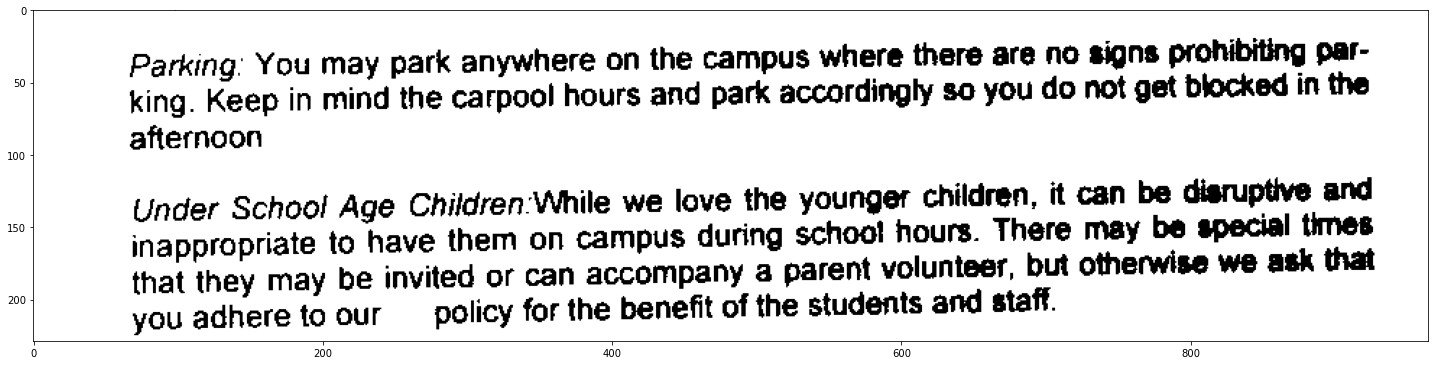

In [90]:
plt.figure(figsize=(25,15))
plt.imshow(processed,'gray')
cv.imwrite(f'results/{file_name}_adaptive_unzoomed.png',processed)

In [91]:
# Tesseract results of adaptive otsu thresholding

process_tesseract(f'{file_name}_adapt_unzoomed', processed)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly 80 you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during schoo! hours. There may be special times
that they may be invited or can accompany 4 parent volunteer, but otherwise we ask that
you adhere to our —_ policy for the benefit of the students and staff.



# Adaptive Thresholding with Mean
---

In [25]:
# Determine how to replace pixel based on neighbour values (mean)

def process_mean_area(image, int_h, int_w, C):
    
    curr_pixel = image[len(image)-int_h, len(image[0])-int_w]
    
    total = 0
    for height in range(len(image)):
        for width in range(len(image[0])):
            total += image[height,width]
    
    image_mean = total/img_size(image)
    
    if curr_pixel < image_mean - C: # C = 10 for sample 1, 5 for sample 2
        return 0
    else:
        return 255
            

In [26]:
# Adaptive mean thresholding
# Takes in (1) an input image array and neighborhood dimensions ((2) height and (3) width) for each pixel
# (4) An optional C value to be used during binarization, default C = 0

# !!!!Box_height and box_width parameters must be odd!!!!

def adaptive_thresh_mean(image1, box_height, box_width, C=0):
    processed_img = image1.copy()
    interval_height = int(np.floor(box_height/2))
    interval_width = int(np.floor(box_width/2))
    
    print(interval_height,interval_width)
    
    for height in range(len(image1)):
        lower_bound_h = height - interval_height
        upper_bound_h = height + interval_height
        diff_h = 0
        
        if height < interval_height:
            lower_bound_h = 0
            upper_bound_h = height + (interval_height)
        elif height > (len(image1) - (interval_height + 1)):
            lower_bound_h = height - (interval_height)
            upper_bound_h = len(image1)
            diff_h = interval_height - (len(image1) - height)
            
            
        for width in range(len(image1[0])):
            diff_w = 0
            lower_bound_w = width - interval_width
            upper_bound_w = width + interval_width
            
            if width < interval_width:
                lower_bound_w = 0
                upper_bound_w = width + (interval_width)
            elif width > (len(image1[0]) - (interval_width + 1)):
                lower_bound_w = width - (interval_width)
                upper_bound_w = len(image1[0])
                diff_w = interval_width - (len(image1[0]) - width)
                
            img_snip = image1[lower_bound_h:upper_bound_h, lower_bound_w:upper_bound_w]

            if img_snip.size == 0:
                continue
            processed_img[height, width] = process_mean_area(img_snip, (interval_height - diff_h), 
                                                             (interval_width - diff_w), C)
    return processed_img

8 8


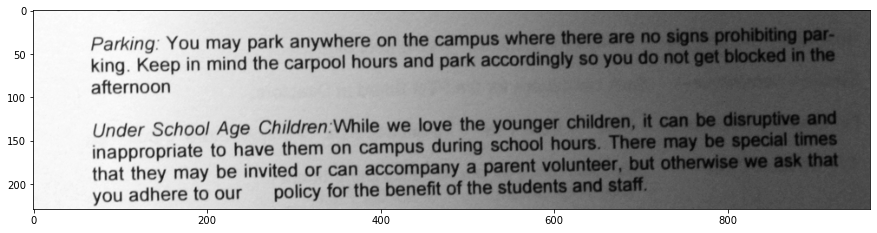

In [31]:
file_name = 'sample01'
image = cv.imread('sample01.png',0)
using_C = False
C = 10 # C = 10 for sample 1, 5 for sample 2

# Display original image
plt.figure(figsize = (15,15))
plt.imshow(image,'gray')
if C != 0:
    using_C = True

processed_mean = adaptive_thresh_mean(image, 17, 17, C)

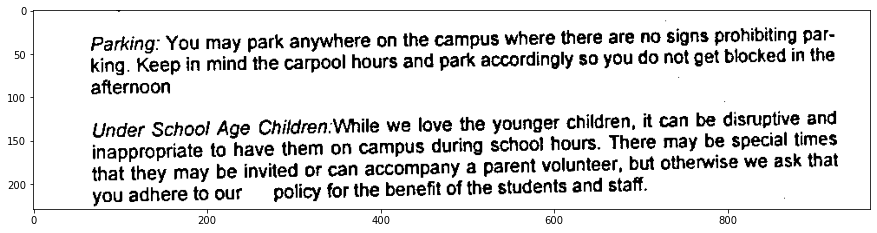

In [33]:
plt.figure(figsize = (15,15))
plt.imshow(processed_mean,'gray')

if using_C:
    cv.imwrite(f'results/{file_name}_adaptive_mean_c.png',processed_mean)
else:
    cv.imwrite(f'results/{file_name}_adaptive_mean.png',processed_mean)

In [35]:
# Tesseract results of adaptive mean thresholding (optional C value)

if using_C:
    process_tesseract(f'{file_name}_adapt_mean_c', processed_mean)
else:
    process_tesseract(f'{file_name}_adapt_mean', processed_mean)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children.While we love the younger children, it can be disruptive and
inappropriate to have them on campus during schoo! hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our ~— policy for the benefit of the students and staff.



# Accuracy Calculation
---

In [71]:
# Judging character by character

def calculate_acc(method, sol):
    num_correct = 0
    
    if len(sol) > len(method):
        max_len = len(sol)
        length = len(method)
    else:
        max_len = len(method)
        length = len(sol)
    
    for char in range(length):
        if method[char] == sol[char]:
            num_correct += 1
    
    score = (num_correct/max_len)*100
    return score

In [80]:
file_name = 'sample02'

# Open file with 100% accuracy (solution created judging by eye)
solution = get_file(f'{file_name}_actual_text', True)

# Open files of different thresholding methods
original = get_file(f'{file_name}_original_output', True)
global_otsu = get_file(f'{file_name}_global_output', True)
adapt_otsu = get_file(f'{file_name}_adapt_output', True)
adapt_mean = get_file(f'{file_name}_adapt_mean_output', True)
adapt_mean_c = get_file(f'{file_name}_adapt_mean_c_output', True)


print("Original: \t",calculate_acc(original, solution))
print("Global otsu: \t",calculate_acc(global_otsu, solution))
print("Adaptive otsu: \t",calculate_acc(adapt_otsu, solution))
print("Adaptive mean: \t",calculate_acc(adapt_mean, solution))
print("Adaptive mean with C: \t",calculate_acc(adapt_mean_c, solution))

Original: 	 2.5193798449612403
Global otsu: 	 0.1937984496124031
Adaptive otsu: 	 3.8181818181818183
Adaptive mean: 	 0.7751937984496124
Adaptive mean with C: 	 20.54263565891473
